# Описание проекта
<p>
    Я — маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Моя задача — разобраться в причинах и помочь компании выйти в плюс.
    </p>
<p>
    Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:<br>
- лог сервера с данными об их посещениях,<br> 
- выгрузка их покупок за этот период,<br>
- рекламные расходы.
    </p>
<p>
    Предстоит изучить:<br>
- откуда приходят пользователи и какими устройствами они пользуются,<br>
- сколько стоит привлечение пользователей из различных рекламных каналов;<br>
- сколько денег приносит каждый клиент,<br>
- когда расходы на привлечение клиента окупаются,<br>
- какие факторы мешают привлечению клиентов.
    </p>

## Загрузим данные и подготовим их к анализу

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

Изучим данные и выполним предобработку.

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

Посмотрим информацию по таблицам для дальнейшей предобработки:

In [3]:
print('visits', visits.info())
print('\n')
print('orders', orders.info())
print('\n')
print('costs', costs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
visits None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
orders None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (tota

Как видим, все столбцы с датой и временем нужно перевести в формат datetime, но для начала приведем названия столбцов к единому регистру

In [4]:
visits = visits.rename(columns ={
    'User Id':'user_id',
    'Session Start':'session_start',
    'Session End':'session_end'
})
visits.columns = visits.columns.str.lower()
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [5]:
orders = orders.rename(columns ={
    'User Id':'user_id',
    'Event Dt':'event_dt',
    'Revenue':'revenue'
})
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [6]:
costs.columns = costs.columns.str.lower()
costs['dt'] = pd.to_datetime(costs['dt'])
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB


Теперь, со столбцами, как и с типами данных в них, все в порядке! К тому же, у нас в руках данные без пропусков! Проверим дубликаты:

In [7]:
print('visits dups:', visits.duplicated().sum())
print('orders dups:', orders.duplicated().sum())
print('costs dups:', costs.duplicated().sum())

visits dups: 0
orders dups: 0
costs dups: 0


Отлично! И дубликатов тоже нет!

## Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

Создадим функцию профилей пользователей <b>get_profiles():

In [8]:
def get_profiles(sessions, orders, ad_costs):
    
    # сортируем сессии по ID пользователя и дате привлечения
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    # проверяем, является ли пользователь платящим
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    # Приводим столбцы dt к формату datetime для корректного объединения
    profiles['dt'] = pd.to_datetime(profiles['dt'])
    ad_costs['dt'] = pd.to_datetime(ad_costs['dt'])

    # Предполагаем, что в ad_costs есть столбцы 'dt', 'channel' и 'costs'
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

Проверим, что возвращает функция:

In [9]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Создадим функцию для подсчета удержания - <b>get_retention():

In [10]:
def get_retention(profiles, sessions, observation_date, horizon, dimensions = [], ignore_horizon = False):
    
    # решаем какие столбцы оставим для группировки удержания, столбец признака платящего пользователя остается всегда
    dimensions = ['payer'] + dimensions
    
    # оттсекаем всех пользователей, которые не могли "дожить" до нужного горизонта 
    # (присоединились позже чем observation_date - horizon)
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # формируем массив сырых данных
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on = 'user_id', how = 'left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    
    # функция группировки по нужному набору измерений
    def group_by_dimensions(df, dims, horizon):     
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')     # строим "треугольную таблицу" 
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) # определяем размеры когорт
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   # присоединяем размеры когорт к треугольной таблице
        result = result.div(result['cohort_size'], axis = 0)                                                     # делим каждый из столбцов на размер когорты - расчитываем % удержания (retention rate)
        result = result[['cohort_size'] + list(range(horizon))]                                             # оставляем только наблюдения до нужного горизонта и столбец размеров когорт
        result['cohort_size'] = cohort_sizes                                                                     # пересприсваиваем столбец размеров когорт, ведь во время деления он превратился в 1
        return result
    
    # расчитываем удержание 
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon)
    
    # рассчитываем удержание по всем параметрам + дата
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon)
    
    # возвращаем и таблицы удержания и сырые данные (чтобы в случае чего можно было в них покопаться при отладке)
    return result_raw, result_grouped, result_in_time

Пропишем функцию для подсчета конверсии <b>get_conversion():

In [11]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

Пропишем функцию по подсчету LTV - <b> get_ltv:

In [12]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon,
    dimensions=[],
    ignore_horizon=False,
):
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о выручке в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # вычисляем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # считаем сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV:
        # делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        # считаеи САС
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        # считаем ROI
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon))]
        return result, roi
    # получаем таблицу LTV, ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon
    )
    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []
    # получаем таблицу динамики LTV, ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )


Пропишем функцию для сглаживания датафрейма - <b>filter_data()

In [13]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

Пропишем функцию <b>plot_retention()</b> — для построения графика Retention Rate:

In [14]:
def plot_retention(retention, retention_history, horizon, window):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержания первого дня
    retention = retention.drop(columns=['cohort_size', 0])

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey = ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные, строим сводную таблицу и график по ней
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon-1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey = ax3)
    # фильтруем данные, строим сводную таблицу и график по ней
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # исключаем наложение графиков друг на друга
    plt.tight_layout()

    plt.show()

Пропишем функцию <b>plot_conversion()</b> — для построения графика конверсии:

In [15]:
def plot_conversion(conversion, conversion_history, horizon, window):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 8))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')
    plt.legend(title='channel', bbox_to_anchor=(0, 1.05), loc='lower left') # Перемещаем легенду за пределы графика
    
    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon)) 
    plt.legend(title='channel', bbox_to_anchor=(0, 1.05), loc='lower left') # Перемещаем легенду за пределы графика
    plt.tight_layout()
    plt.show()

Пропишем функцию <b>plot_ltv_roi</b> — для визуализации LTV и ROI.

In [16]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))
    plt.legend(loc='upper center', mode='expand', borderaxespad=0, ncol=3) # растягиваем легенду по ширине графика
    
    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))
    plt.legend(loc='upper center', mode='expand', borderaxespad=0, ncol=3) # растягиваем легенду по ширине графика
    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

### Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.

In [17]:
# получим профили пользователей
profiles = get_profiles(visits, orders, costs)

# определим минимальную и максимальную даты привлечения пользователей
min_acquisition_date = profiles['dt'].min().date()
max_acquisition_date = profiles['dt'].max().date()

print(f"Минимальная дата привлечения пользователей: {min_acquisition_date}")
print(f"Максимальная дата привлечения пользователей: {max_acquisition_date}")

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


Даты не противоречат условиям задачи.

### Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

,region,total_users,paying_users,paying_share
0,United States,100002,6902,0.069019
1,Germany,14981,616,0.041119
2,UK,17575,700,0.039829
3,France,17450,663,0.037994


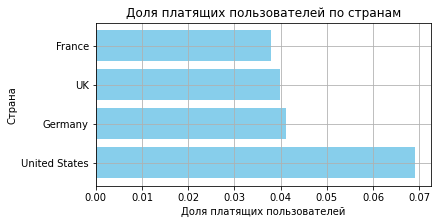

In [18]:
# группируем данные по стране
country_stats = (
    profiles.groupby('region')
    .agg(total_users=('user_id', 'nunique'),
         paying_users=('payer', 'sum'))
)

# вычислим долю платящих пользователей
country_stats['paying_share'] = country_stats['paying_users'] / country_stats['total_users']

country_stats = country_stats.sort_values(by='paying_share', ascending=False).reset_index()
display(country_stats)

# визуализируем
plt.figure(figsize=(6, 3))
plt.barh(country_stats['region'], country_stats['paying_share'], color='skyblue')
plt.xlabel('Доля платящих пользователей')
plt.ylabel('Страна')
plt.title('Доля платящих пользователей по странам')
plt.grid(True)
plt.show()

Пользователи из США имеют больше всего платящих пользователей. Количество всех пользователей в США внушительное, но глядя на процентное соотношение, можно увидеть, что разрыв в доле платящих между странами не такой же колоссальный, но приличный.

### Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

,device,total_users,paying_users,paying_share
0,Mac,30042,1912,0.063644
1,iPhone,54479,3382,0.062079
2,Android,35032,2050,0.058518
3,PC,30455,1537,0.050468


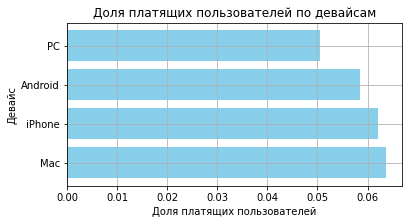

In [19]:
# группируем данные по устройству
device_stats = (
    profiles.groupby('device')
    .agg(total_users=('user_id', 'nunique'),
         paying_users=('payer', 'sum'))
)

# вычислим долю платящих пользователей
device_stats['paying_share'] = device_stats['paying_users'] / device_stats['total_users']

device_stats = device_stats.sort_values(by='paying_share', ascending=False).reset_index()
display(device_stats)

# визуализируем
plt.figure(figsize=(6, 3))
plt.barh(device_stats['device'], device_stats['paying_share'], color='skyblue')
plt.xlabel('Доля платящих пользователей')
plt.ylabel('Девайс')
plt.title('Доля платящих пользователей по девайсам')
plt.grid(True)
plt.show()

iPhone имеет наибольшее количество пользователей, и у него также относительно высокая доля платящих пользователей. Хотя Mac, несмотря на меньшее кол-во пользователей (по сравнению с iPhone), имеет самую высокую долю платящих (6.36%).
Остальные платформы хоть и отстают, но нельзя сказать, что отстают сильно.

### Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

,channel,total_users,paying_users,paying_share
0,FaceBoom,29144,3557,0.122049
1,AdNonSense,3880,440,0.113402
2,lambdaMediaAds,2149,225,0.104700
3,TipTop,19561,1878,0.096007
4,RocketSuperAds,4448,352,0.079137
5,WahooNetBanner,8553,453,0.052964
6,YRabbit,4312,165,0.038265
7,MediaTornado,4364,156,0.035747
8,LeapBob,8553,262,0.030633
9,OppleCreativeMedia,8605,233,0.027077


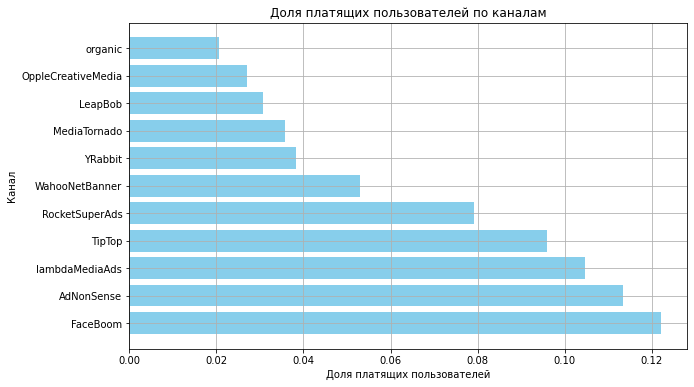

In [20]:
# группируем данные по каналу
channel_stats = (
    profiles.groupby('channel')
    .agg(total_users=('user_id', 'nunique'),
         paying_users=('payer', 'sum'))
)

# вычислим долю платящих пользователей
channel_stats['paying_share'] = channel_stats['paying_users'] / channel_stats['total_users']

channel_stats = channel_stats.sort_values(by='paying_share', ascending=False).reset_index()
display(channel_stats)

# визуализируем
plt.figure(figsize=(10, 6))
plt.barh(channel_stats['channel'], channel_stats['paying_share'], color='skyblue')
plt.xlabel('Доля платящих пользователей')
plt.ylabel('Канал')
plt.title('Доля платящих пользователей по каналам')
plt.grid(True)
plt.show()

FaceBoom оказался самым успешным каналом с точки зрения количества платящих пользователей: 3557, что составляет 12.2% от общего числа пользователей. Это самый высокий показатель в таблице.
AdNonSense и lambdaMediaAds также показывают достаточно высокие результаты с долями платящих пользователей 11.3% и 10.5% соответственно, хотя абсолютное количество платящих пользователей меньше.
Organic же привлёк больше всего пользователей (56,439), но доля платящих оказалась самой низкой — всего 2%.

### Промежуточный итог:
<p>
Соединённые Штаты демонстрируют самую высокую долю платящих пользователей — 6.9%, что делает этот регион ключевым для монетизации.<br>
Германия, Великобритания и Франция имеют значительно меньшие доли платящих — около 4%.<br>
<b>Вывод:</b> США является наиболее ценным рынком с точки зрения платящих пользователей, в то время как другие крупные европейские рынки (Германия, UK, Франция) показывают более низкий уровень конверсии в платящих клиентов.
</p>
<p>
Пользователи с Mac и iPhone демонстрируют наибольшие доли платящих пользователей — 6.4% и 6.2% соответственно.<br>
Android и PC также привлекают большое количество пользователей, но их доли платящих ниже — 5.9% и 5.0%.<br>
<b>Вывод:</b> устройства Apple (Mac и iPhone) привлекают более платежеспособную аудиторию.
</p>
<p>
FaceBoom, AdNonSense, и lambdaMediaAds показали лучшие результаты с долей платящих пользователей 10-12%.<br>
TipTop привлёк большое количество пользователей, но доля платящих ниже (9.6%).<br>
WahooNetBanner, YRabbit, и organic оказались наименее эффективными с долей платящих менее 5%, несмотря на высокий объём привлечённых пользователей.<br>
<b>Вывод:</b> наибольший успех показали каналы FaceBoom и AdNonSense, в то время как органический трафик менее эффективен для монетизации.
</p>
<p>
<b>Общий вывод:</b> наилучшие результаты дают США по регионам и Apple по устройствам, а из рекламных каналов лидируют FaceBoom и AdNonSense.
</p>

## Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. Затем на другом графике визуализируйте динамику изменения расходов во времени по месяцам по каждому источнику.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

### Посчитаем общую сумму расходов на маркетинг

In [21]:
print("Общая сумма расходов на маркетинг:", round(costs['costs'].sum(), 2))

Общая сумма расходов на маркетинг: 105497.3


### Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.

,channel,costs
0,TipTop,54751.30
1,FaceBoom,32445.60
2,WahooNetBanner,5151.00
3,AdNonSense,3911.25
4,OppleCreativeMedia,2151.25
5,RocketSuperAds,1833.00
6,LeapBob,1797.60
7,lambdaMediaAds,1557.60
8,MediaTornado,954.48
9,YRabbit,944.22


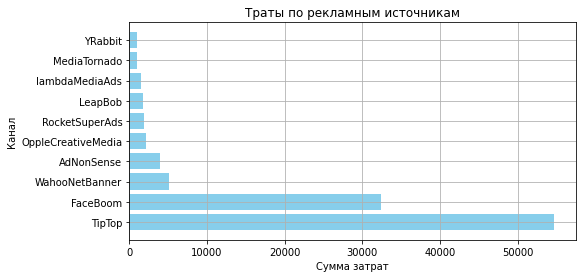

In [22]:
cost_stats = costs.groupby('channel')['costs'].sum().sort_values(ascending=False).reset_index()
display(cost_stats)

# Создание графика
plt.figure(figsize=(8, 4))
plt.barh(cost_stats['channel'], cost_stats['costs'], color='skyblue')
plt.xlabel('Сумма затрат')
plt.ylabel('Канал')
plt.title('Траты по рекламным источникам')
plt.grid(True)
plt.show()

### Построим график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. Затем на другом графике визуализируем динамику изменения расходов во времени по месяцам по каждому источнику.

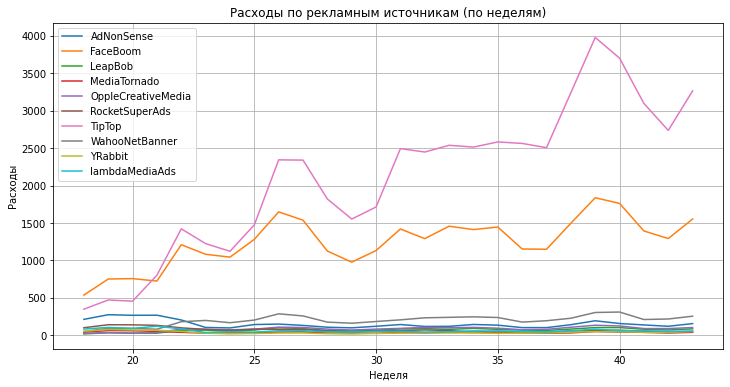

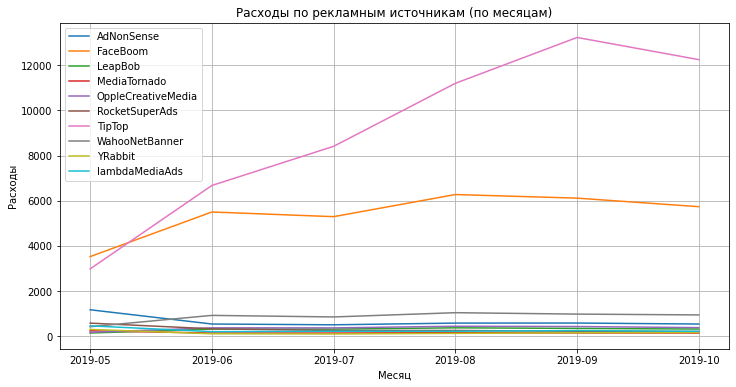

In [23]:
# группируем по неделям
costs['week'] = costs['dt'].dt.isocalendar().week
costs['year'] = costs['dt'].dt.year
weekly_expenses = costs.groupby(['year', 'week', 'channel'])['costs'].sum().reset_index()

# группируем по месяцам
costs['month'] = costs['dt'].dt.to_period('M')
monthly_expenses = costs.groupby(['month', 'channel'])['costs'].sum().reset_index()

# визуализируем расходы по неделям
plt.figure(figsize=(12, 6))
for channel in weekly_expenses['channel'].unique():
    # для каждого канала выбираем строки, соответствующие этому каналу из weekly_expenses
    channel_data = weekly_expenses[weekly_expenses['channel'] == channel]
    plt.plot(channel_data['week'], channel_data['costs'], label=channel)
plt.title('Расходы по рекламным источникам (по неделям)')
plt.xlabel('Неделя')
plt.ylabel('Расходы')
plt.legend()
plt.grid()
plt.show()

# визуализируем расходы по месяцам
plt.figure(figsize=(12, 6))
for channel in monthly_expenses['channel'].unique():
    # для каждого канала выбираем строки, соответствующие этому каналу из monthly_expenses
    channel_data = monthly_expenses[monthly_expenses['channel'] == channel]
    plt.plot(channel_data['month'].astype(str), channel_data['costs'], label=channel)
plt.title('Расходы по рекламным источникам (по месяцам)')
plt.xlabel('Месяц')
plt.ylabel('Расходы')
plt.legend()
plt.grid()
plt.show()

На обоих графиках видно, что с течением времени расходы на рекламу увеличивались только для двух каналов - TipTop и FaceBoom. Эти расходы сильно выделяются на фоне остальных.
Все остальные каналы, имеют значительно более низкие расходы. Причем, стоит заметить, что расходы на них стабильны и не возрастают.

<b>Отдельно рассмотрим источники без двух топовых, чтобы было проще увидеть их динамику.

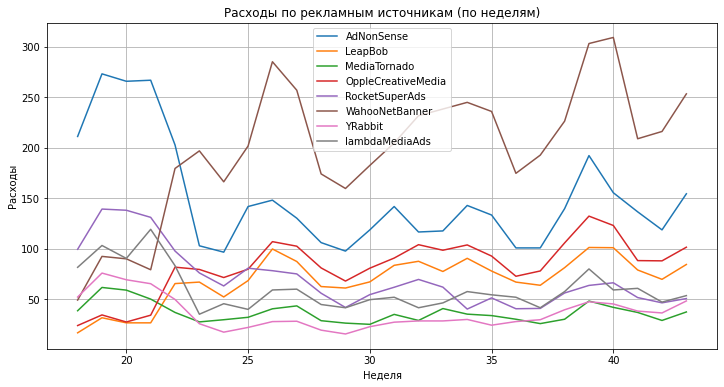

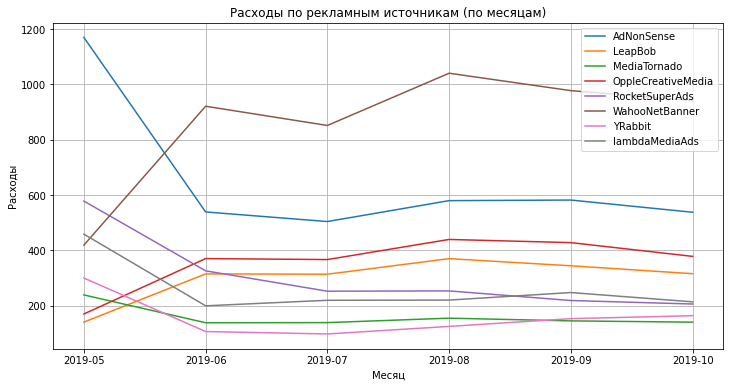

In [62]:
# группируем по неделям
costs['week'] = costs['dt'].dt.isocalendar().week
costs['year'] = costs['dt'].dt.year
weekly_expenses = costs.groupby(['year', 'week', 'channel'])['costs'].sum().reset_index()

# исключаем каналы "TipTop" и "FaceBoom"
excluded_channels = ['TipTop', 'FaceBoom']
weekly_expenses = weekly_expenses[~weekly_expenses['channel'].isin(excluded_channels)]

# группируем по месяцам
costs['month'] = costs['dt'].dt.to_period('M')
monthly_expenses = costs.groupby(['month', 'channel'])['costs'].sum().reset_index()

# исключаем каналы "TipTop" и "FaceBoom" из месячных данных
monthly_expenses = monthly_expenses[~monthly_expenses['channel'].isin(excluded_channels)]

# визуализируем расходы по неделям
plt.figure(figsize=(12, 6))
for channel in weekly_expenses['channel'].unique():
    # для каждого канала выбираем строки, соответствующие этому каналу из weekly_expenses
    channel_data = weekly_expenses[weekly_expenses['channel'] == channel]
    plt.plot(channel_data['week'], channel_data['costs'], label=channel)
plt.title('Расходы по рекламным источникам (по неделям)')
plt.xlabel('Неделя')
plt.ylabel('Расходы')
plt.legend()
plt.grid()
plt.show()

# визуализируем расходы по месяцам
plt.figure(figsize=(12, 6))
for channel in monthly_expenses['channel'].unique():
    # для каждого канала выбираем строки, соответствующие этому каналу из monthly_expenses
    channel_data = monthly_expenses[monthly_expenses['channel'] == channel]
    plt.plot(channel_data['month'].astype(str), channel_data['costs'], label=channel)
plt.title('Расходы по рекламным источникам (по месяцам)')
plt.xlabel('Месяц')
plt.ylabel('Расходы')
plt.legend()
plt.grid()
plt.show()

Среди данных каналов видно, что дороже остальных обходится WahooNetBanner, а самым дешевым YRabbit. Все так же хочу отметить, что расходы на все эти каналы стабильны и не возрастают.

### Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используем профили пользователей.

,channel,costs,total_users,CAC
0,TipTop,54751.30,19561,2.799003
1,FaceBoom,32445.60,29144,1.113286
2,AdNonSense,3911.25,3880,1.008054
3,lambdaMediaAds,1557.60,2149,0.724802
4,WahooNetBanner,5151.00,8553,0.602245
5,RocketSuperAds,1833.00,4448,0.412095
6,OppleCreativeMedia,2151.25,8605,0.250000
7,YRabbit,944.22,4312,0.218975
8,MediaTornado,954.48,4364,0.218717
9,LeapBob,1797.60,8553,0.210172


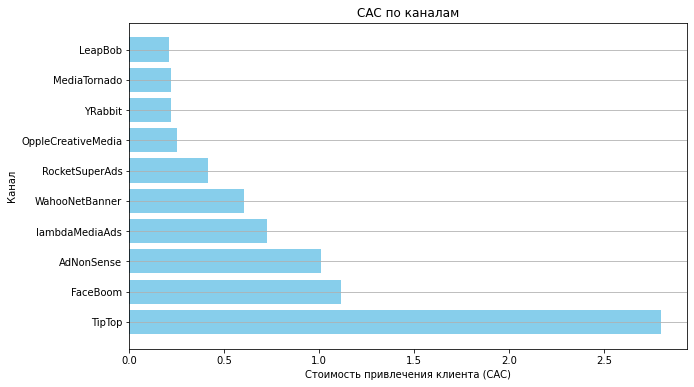

In [24]:
# считаем общие расходы на рекламу по каналам
total_costs = costs.groupby('channel')['costs'].sum().reset_index()

# считаем количество пользователей по каналам
user_counts = profiles.groupby('channel')['user_id'].nunique().reset_index()
user_counts = user_counts.rename(columns={'channel': 'channel', 'user_id': 'total_users'})

# объединяем данные о расходах и пользователях
cac_data = pd.merge(total_costs, user_counts, on='channel')

# рассчитываем CAC
cac_data['CAC'] = cac_data['costs'] / cac_data['total_users']

cac_data = cac_data.sort_values(by='CAC', ascending=False).reset_index(drop=True)
display(cac_data)

# визуализируем
plt.figure(figsize=(10, 6))
plt.barh(cac_data['channel'], cac_data['CAC'], color='skyblue')
plt.ylabel('Канал')
plt.xlabel('Стоимость привлечения клиента (CAC)')
plt.title('CAC по каналам')
plt.grid(axis='y')
plt.show()

<p>
TipTop имеет самый высокий показатель CAC — 2.799. Рекламная кампания на этом канале в несколько раз дороже остальных каналов.
</p>
<p>
FaceBoom и AdNonSense также имеют относительно высокие показатели CAC — 1.113 и 1.008 соответственно. Эти каналы обходятся дорого, хотя и не так сильно, как TipTop.
</p>
<p>
LeapBob, MediaTornado, YRabbit, и OppleCreativeMedia демонстрируют наиболее низкие CAC. Особенно LeapBob с показателем 0.210, что делает его самым дешевым каналом для привлечения пользователей. Эти кналы могут привлекать пользователей с минимальными затратами.
</p>
<p>
FaceBoom и TipTop имеют значительные расходы на рекламу (54751.30 и 32445.60 соответственно), но в то же время различаются по числу привлеченных пользователей и стоимости привлечения. TipTop привлекло меньше пользователей, чем FaceBoom, несмотря на большие затраты, что делает этот канал менее выгодным.
</p> 

## Оценим окупаемость рекламы

### Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

В качестве даты наблюдения поставим 1 ноября 2019 года, в качестве горизонта - 14 дней.

In [25]:
observation_date = datetime(2019, 11, 1).date()
horizon = 14

Вызовем нашу функцию get_ltv(), присвоив соответстветствующим переменным, для дальнейшего визуализирования

In [26]:
paid_users = profiles[profiles['channel'] != 'organic']
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(paid_users, orders, observation_date, horizon)#, dimensions=['channel'])
ltv.head()

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
cohort,,,,,,,,,,,,,,,
All users,88644,0.34558,0.435754,0.504507,0.56109,0.611436,0.654368,0.69414,0.729778,0.764619,0.796665,0.826152,0.85207,0.878116,0.90203


Вызываем функцию для визуализации LTV и ROI. Чтобы в динамике график разгладился, в качестве последнего аргумента, передаем окно для сглаживания (из функции filter_data()) - 14 дней.

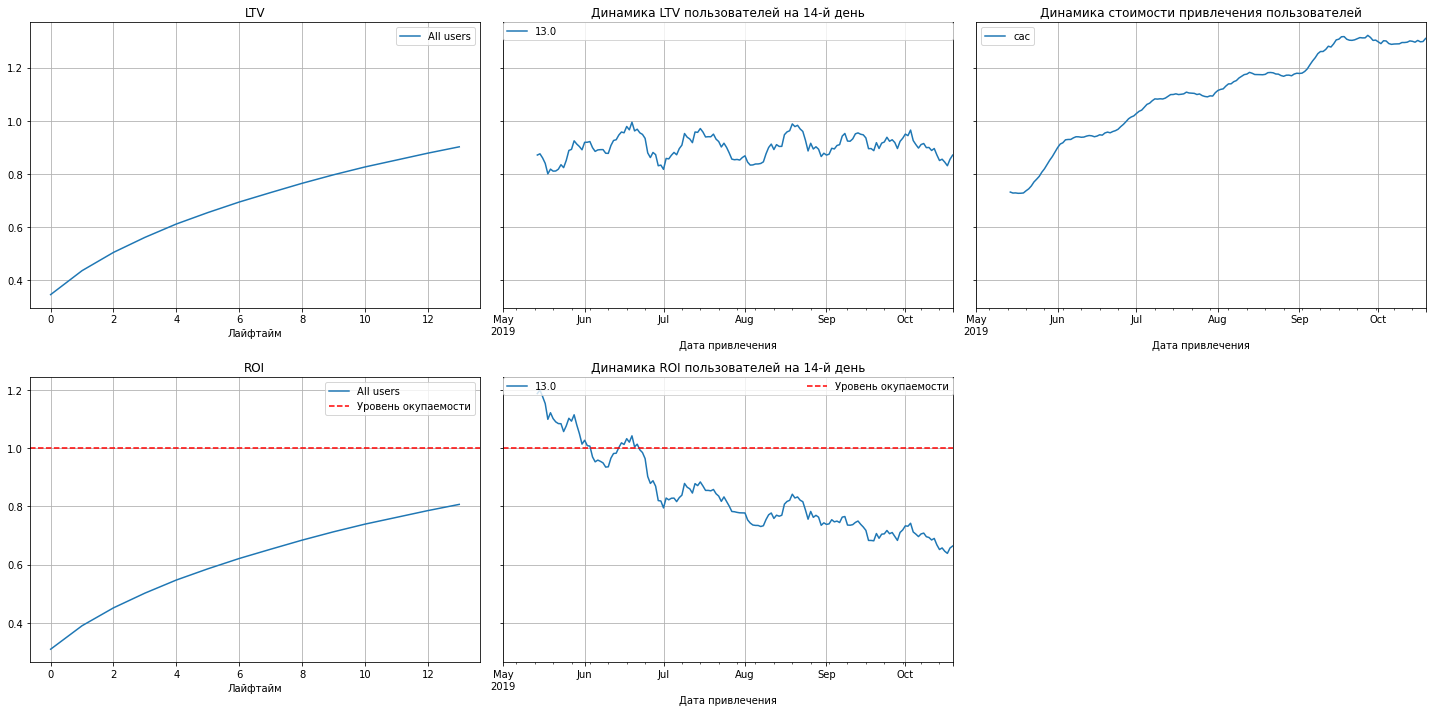

In [27]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, 14)

- Мы видим, что показатели "LTV на 14-й день" колеблется возле отметки в 0.9. 
- Стоимость привлечения пользователей значительно увеличилась. Это может указывать на неэффективность текущих маркетинговых стратегий.
- ROI не достигает уровня окупаемости, что свидетельствует о том, что расходы на привлечение пользователей превышают их ценность для бизнеса.
- Динамика ROI показывает значительное снижение с 1.2 до 0.6, что может быть признаком ухудшения финансовых результатов и устойчивости бизнеса. Это может также указывать на необходимость пересмотра подхода к маркетингу и удержанию пользователей.
- Чтобы разобраться с причинами таких изменений нам необходимо провести более глубокий анализ данных.

### Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.

Вызовем функцию для подсчета конверсии

In [28]:
conversion_raw, conversion, conversion_history = get_conversion(paid_users, orders, observation_date, horizon, dimensions=['channel'])

Вызовем функцию для визуализации конверсии. Так же пропишем окно для сглаживания динамики в 14 дней.

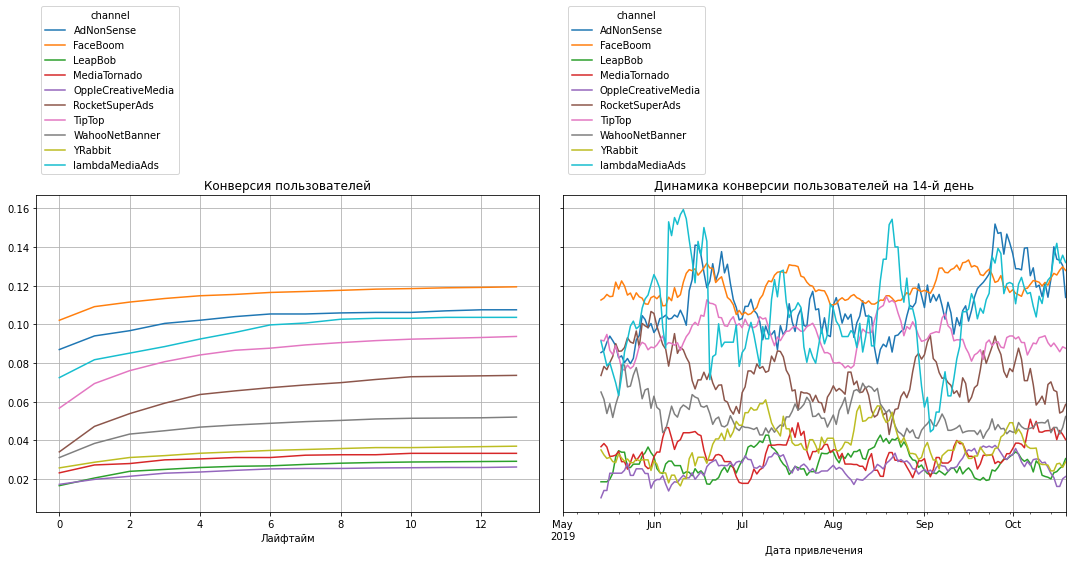

In [29]:
plot_conversion(conversion, conversion_history, horizon, 14)

- FaceBoom, AdNonSense показывает наиболее высокие коэффициенты конверсии по сравнению с другими каналами, что указывает на их высокую эффективность в привлечении платящих пользователей.
- RocketSuperAds демонстрирует умеренный рост конверсии, но не достигает таких высоких значений, как FaceBoom и AdNonSense.
- organic имеет наименьшие коэффициенты конверсии, что может указывать на необходимость пересмотра стратегий для этого канала.
- Если смотреть на динамику, то самым колеблящимся каналом является lambdaMediaAds. Он то достигает верхнего значения в 0.16, то достигает нижнего значения в 0.05

<b>Посмотрим конверсию по странам:

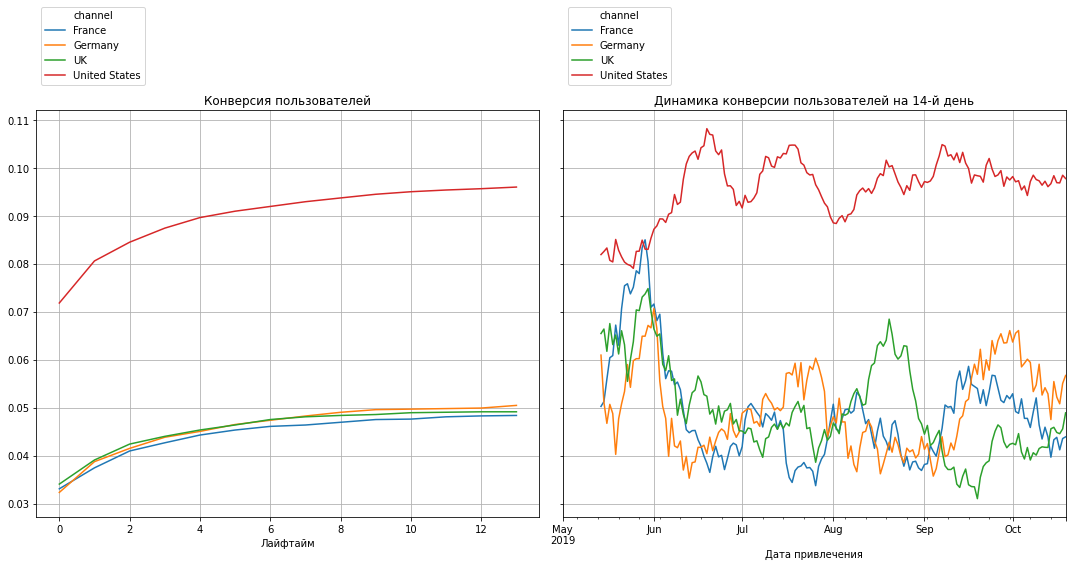

In [39]:
conversion_raw, conversion, conversion_history = get_conversion(paid_users, orders, observation_date, horizon, dimensions=['region'])
plot_conversion(conversion, conversion_history, horizon, 14)

США показывает самый высокий коэффициент конверсии по сравнению с другими странами, что указывает на ее высокую эффективность в привлечении платящих пользователей.
Среди остальных стран лидирующее место по привлечению занимает Германия, а замыкающее Франция. В целом можно увидеть, как показатели разных стран неслабо колеблятся в динамике, но держатся возле показателя 0.4.

<b>Теперь посмотрим конверсию по девайсам:

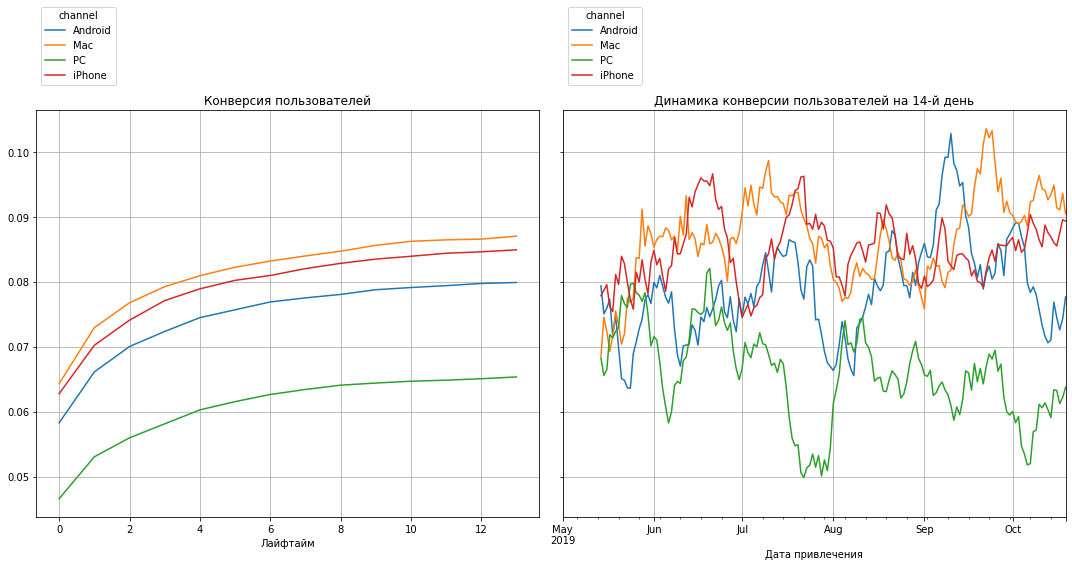

In [40]:
conversion_raw, conversion, conversion_history = get_conversion(paid_users, orders, observation_date, horizon, dimensions=['device'])
plot_conversion(conversion, conversion_history, horizon, 14)

Мы видим, что конверсия Apple устройств на высоте (особенно Мас), достигая 0.065. Немного от их показателей отстает Андроид, достигая 0.06. И, с отстованием на целый пункт, график замыкает РС, с показателемв 0.05.

Теперь вызовем функцию по подсчету удержания

In [41]:
retention_raw, retention, retention_history = get_retention(paid_users, visits, observation_date, horizon, dimensions=['device'])
retention

cohort_size    0         1         2         3         4  \
payer device                                                              
False Android        18988  1.0  0.174953  0.086476  0.051928  0.031336   
      Mac            16150  1.0  0.179195  0.085635  0.049412  0.033065   
      PC             16920  1.0  0.174704  0.087234  0.052364  0.034574   
      iPhone         29276  1.0  0.178098  0.086829  0.052774  0.034533   
True  Android         1695  1.0  0.384661  0.298525  0.250147  0.214159   
      Mac             1597  1.0  0.365059  0.284283  0.202880  0.196619   
      PC              1208  1.0  0.421358  0.333609  0.262417  0.261589   
      iPhone          2810  1.0  0.370463  0.277224  0.233808  0.193594   

                      5         6         7         8         9        10  \
payer device                                                                
False Android  0.024015  0.017485  0.013798  0.011060  0.010006  0.007742   
      Mac      0.023901  0.019505  0.014551  0.012755  0.009102  0.007988   
      PC       0.024232  0.017790  0.014539  0.011170  0.008747  0.007033   
      iPhone   0.025857  0.019436  0.014039  0.011921  0.009940  0.007310   
True  Android  0.206490  0.156342  0.166372  0.146903  0.137463  0.132743   
      Mac      0.172198  0.148403  0.142768  0.136506  0.132123  0.120852   
      PC       0.209437  0.225166  0.192053  0.175497  0.149834  0.163907   
      iPhone   0.185053  0.158363  0.144128  0.135943  0.132384  0.132028   

                     11        12        13  
payer device                                 
False Android  0.006530  0.005477  0.005056  
      Mac      0.006440  0.006254  0.004025  
      PC       0.005437  0.005851  0.005556  
      iPhone   0.006832  0.006319  0.004372  
True  Android  0.110914  0.128614  0.107375  
      Mac      0.115216  0.108954  0.110833  
      PC       0.148179  0.144040  0.124172  
      iPhone   0.120996  0.107473  0.091815

Вызовем функцию для визуализации удержания. Так же пропишем окно для сглаживания динамики в 14 дней.

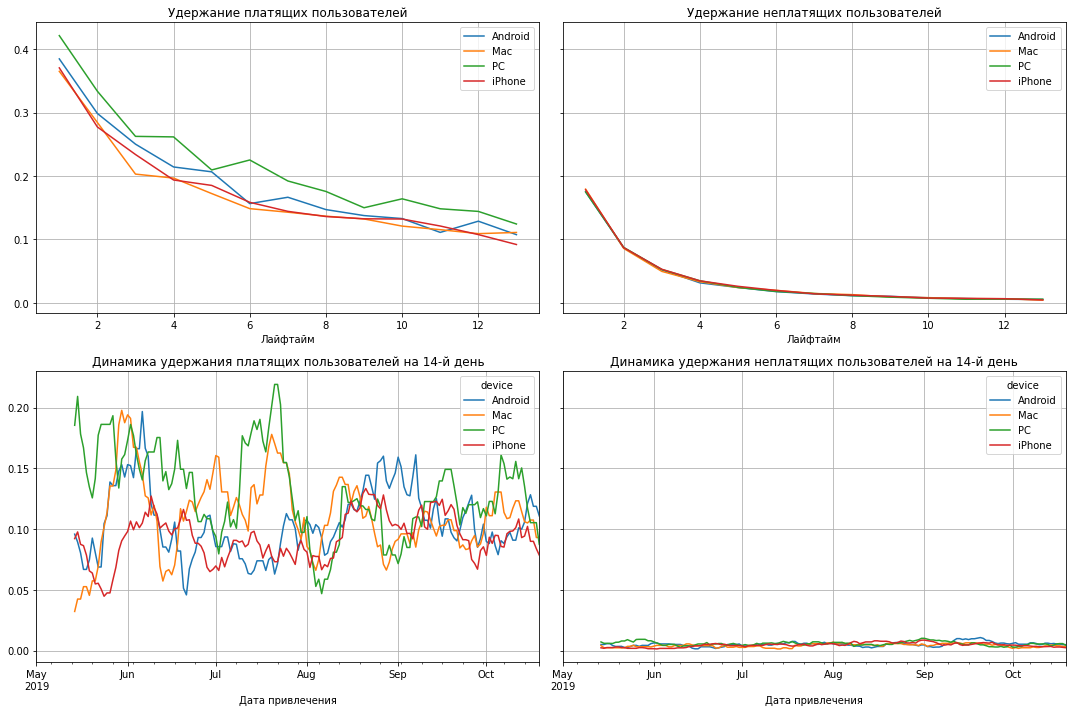

In [42]:
plot_retention(retention, retention_history, horizon, 14)

- Платящие пользователи демонстрируют значительно более высокие показатели удержания по сравнению с неплатящими, что ожидаемо. Удержание постепенно снижается, однако остается на более высоком уровне по сравнению с неплатящими пользователями. Наилучшие результаты удержания платящих пользователей наблюдаются на PC и Android.
- В динамике сильно бросается в глаза упадок удержания PC пользователей. Однакосо временем и он нормализуется и присоединяется к общей тенденции. Удержание неплатящих пользователей колеблется около нуля. Скорей всего они не возвращаются после первоначального использования.

<b>Добавим удержание по странам:

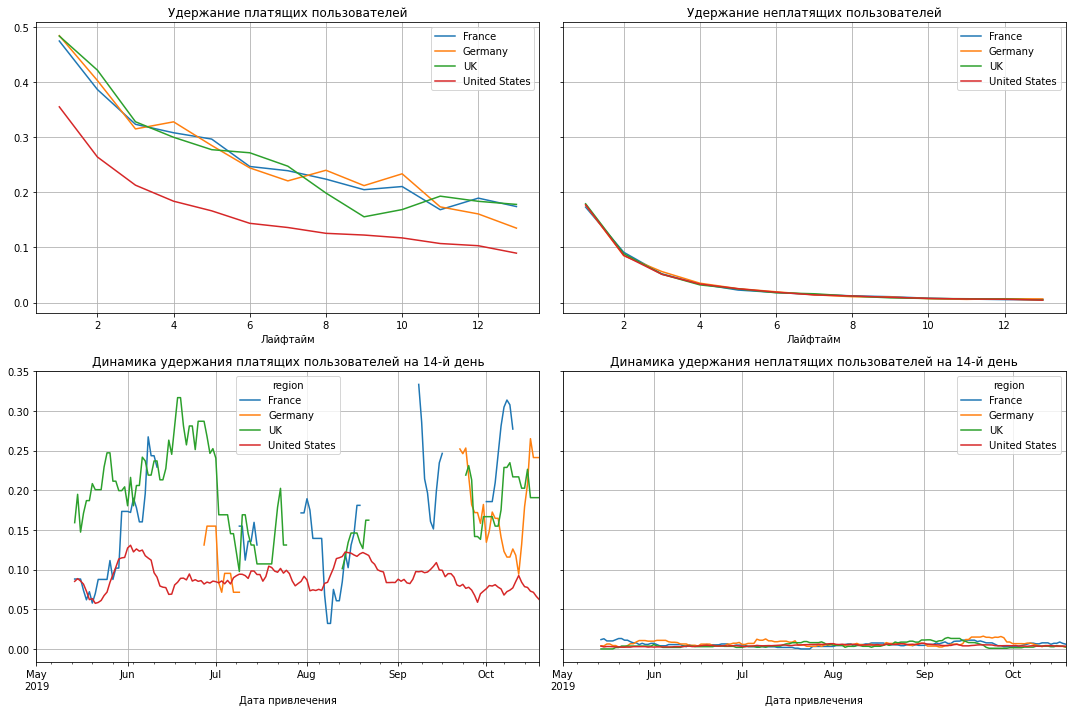

In [45]:
retention_raw, retention, retention_history = get_retention(paid_users, visits, observation_date, horizon, dimensions=['region'])
plot_retention(retention, retention_history, horizon, 14)

Несмотря на высокую конверсию, удерживать платящих пользователей в США не очень получается. Показатели ниже остальных стран. Ровно противоположное тому, что мы видели на графиках с конверсией по странам.

<b>Добавим удержание по каналам:

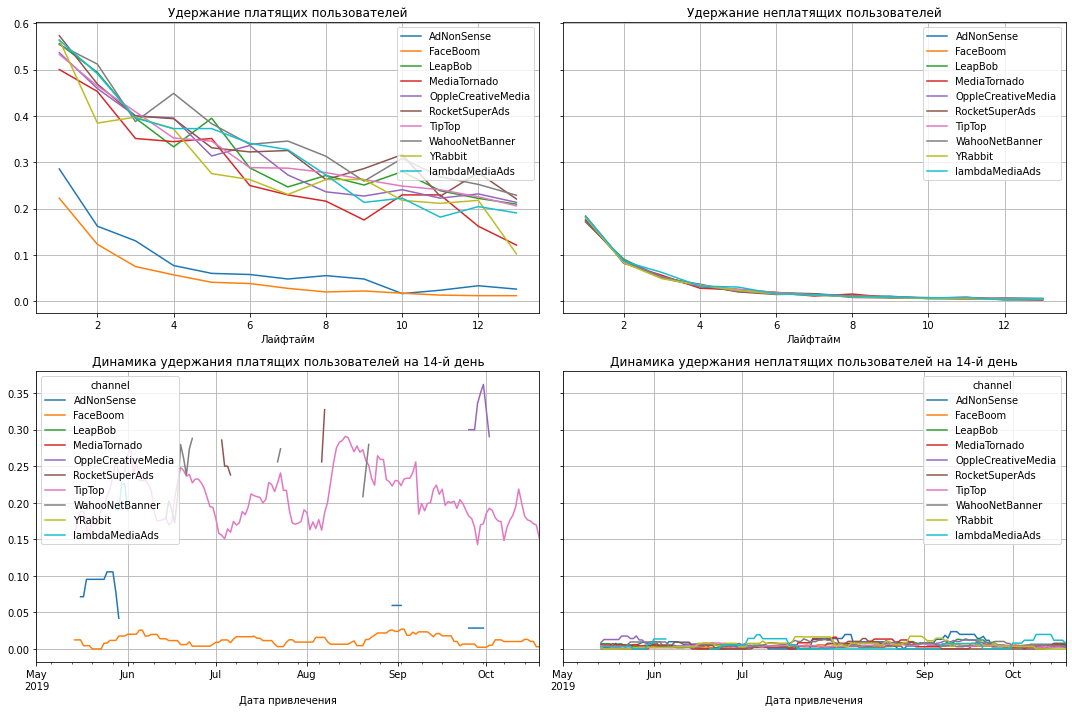

In [52]:
retention_raw, retention, retention_history = get_retention(paid_users, visits, observation_date, horizon, dimensions=['channel'])
plot_retention(retention, retention_history, horizon, 14)

Очень низкое удержание у каналов Faceboom и AdNonSense. Остальные каналы придерживаются общего тренда.

### Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

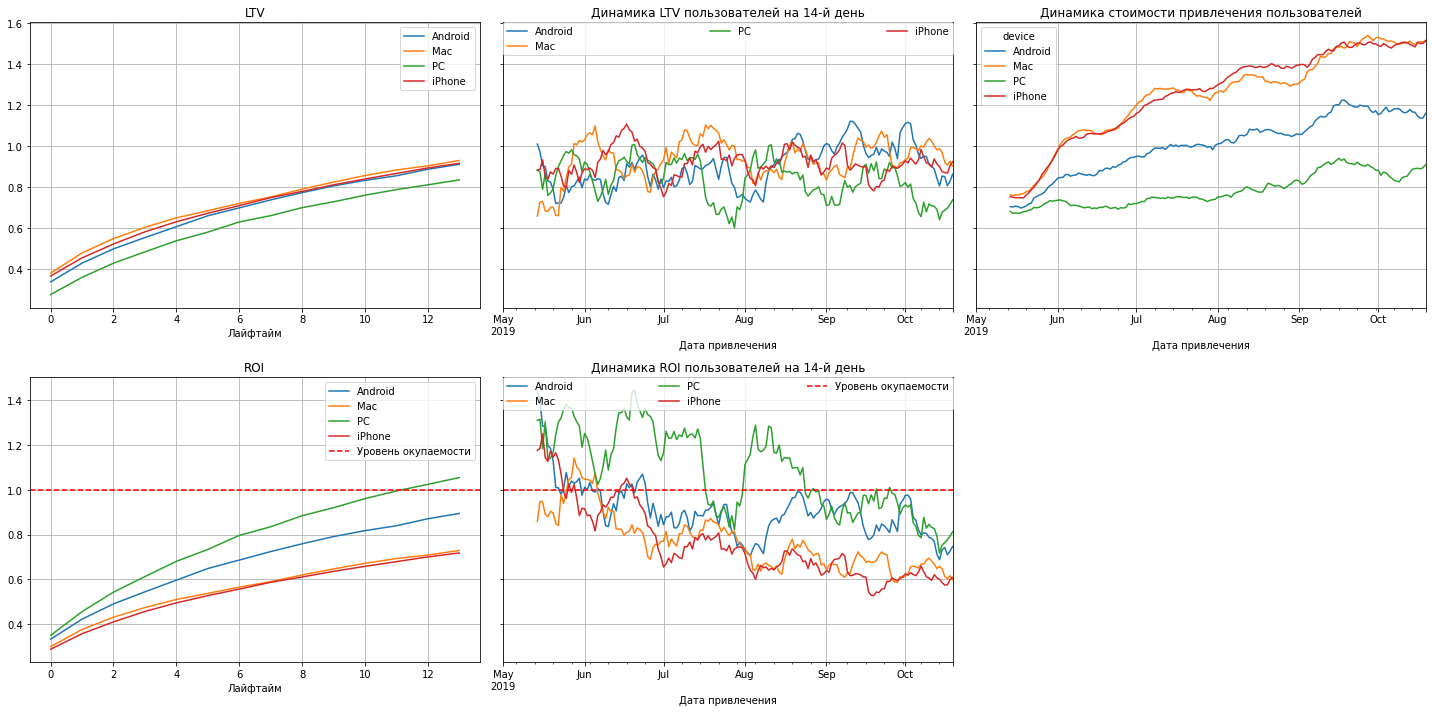

In [56]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(paid_users, orders, observation_date, horizon, dimensions=['device'])
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, 14)

- На графе LTV от общей группы немного отбиваются PC пользователи.
- В динамике виден общий тренд, и показатели все так же колеблятся возле показателя в 0.7
- Стоимость привлечения пользователей для Apple устройств значительно выше чем для Android, а тем более для PC.
- ROI достигает уровня окупаемости только для PC.
- В динамике ROI  видно, что со временем все девайсы падают ниже уровня окупаемости. Хотя РС значительное время оставался над этим порогом.

### Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

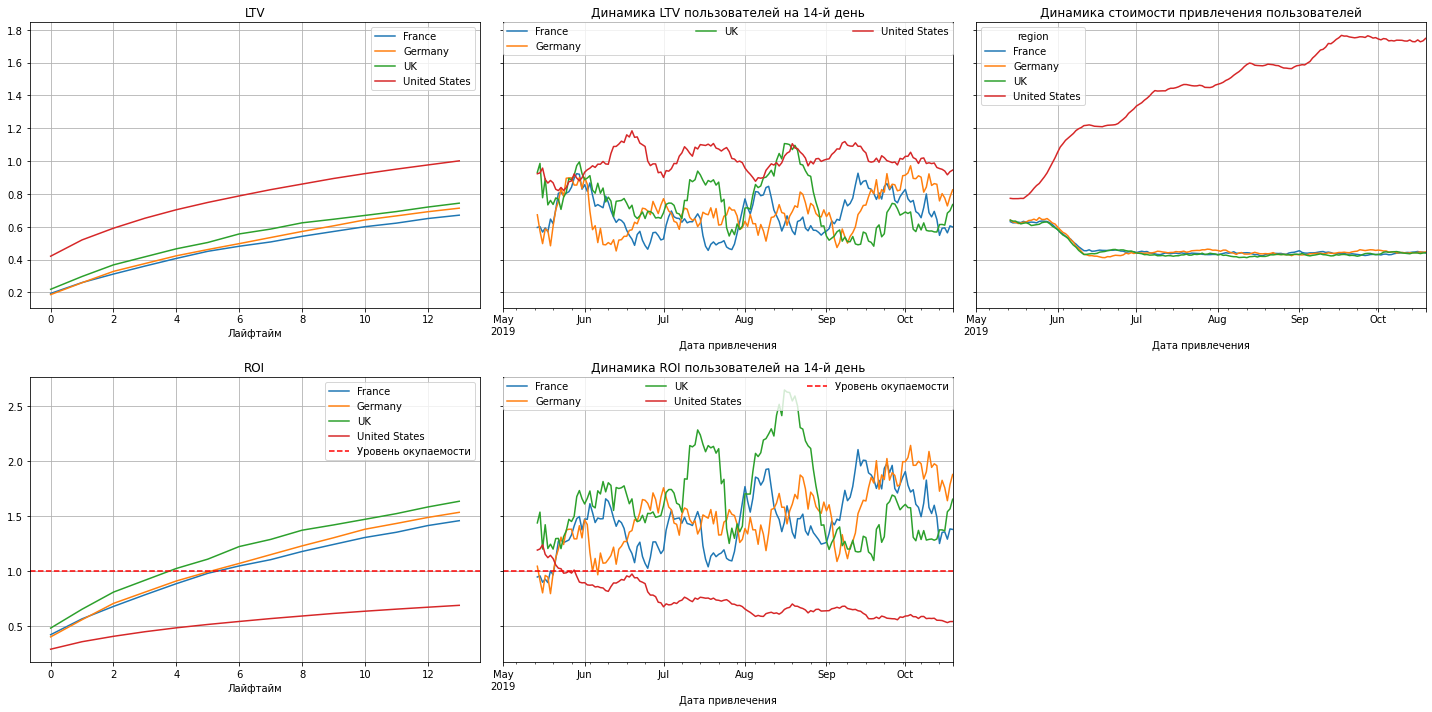

In [60]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(paid_users, orders, observation_date, horizon, dimensions=['region'])
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, 14)

- На графе LTV США явно опережает остальные страны.
- В динамике также США выделяется от основного тренда и выходит на стабильные показатели в последние 2 месяца.
- Стоимость привлечения пользователей из США является самой высокой, обгоняя остальные страны чуть ли не в 4 раза.
- ROI показывает, что затраты на пользователей из США не окупаются.
- В динамике ROI видно, как все страны кроме США не падают ниже уровня окупаемости, и со временем приходят к общему тренду.

### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

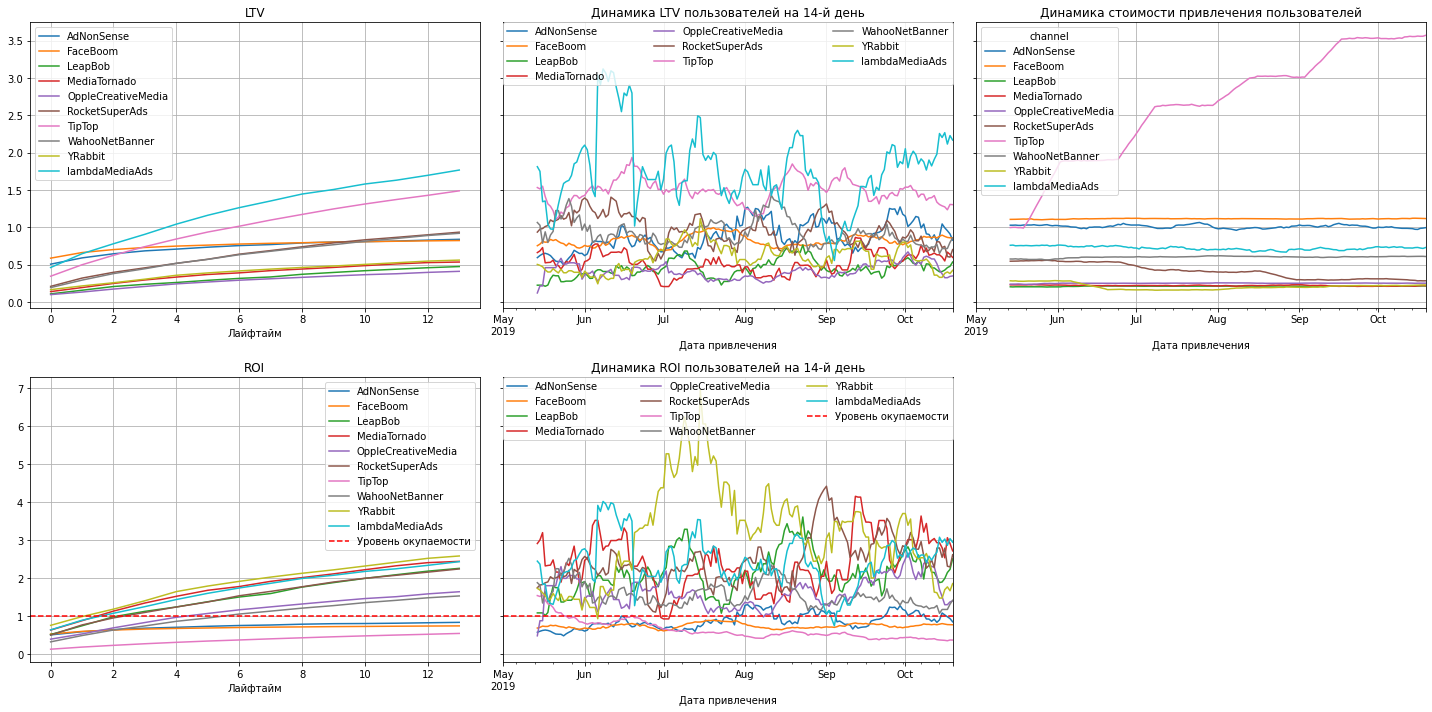

In [58]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(paid_users, orders, observation_date, horizon, dimensions=['channel'])
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, 14)

- Каналы lambdaMediaAds и TipTop выделяются на фоне остальных, показывая наиболее значительный рост LTV. RocketSuperAds также демонстрируют уверенный рост LTV, хотя немного медленнее по сравнению с лидерами. Остальные каналы показывают маленький рост LTV.
- В динамике наблюдаются колебания по всем каналам, но особенно у lambdaMediaAds. В основном наблюдается тренд на стабилизацию.
- В динамике САС канал TipTop имеет резкое и значительное увеличение стоимости привлечения пользователей. Остальные каналы, демонстрируют стабильную и относительно низкую стоимость привлечения.
- В целом, каналы оправдывают вложения в них, за исключением AdNonSense, Faceboom, TipTop - эти три даже не достигают уровня окупаемости.
- В динамике мы так же видим как эти три канала колеблятся ниже уровня окупаемости. Хотя и AdNonSense несколько раз выходил на уровень окупаемости несколько раз. Другие каналы, находятся выше этого уровня, но показывают более нестабильные результаты с периодическими колебаниями, особенно выделяется YRabbit. Однако со временем на графике начинает прослеживаться общий тренд.
- <b>Общий вывод:</b> По-моему, lambdaMediaAds является наиболее эффективным каналом с точки зрения окупаемости (LTV и ROI).<br>
TipTop демонстрирует высокую стоимость привлечения, что ставит под сомнение его эффективность.<br>
Каналы с сильными колебаниями могут принести высокий доход в краткосрочной перспективе, но требуют тщательного мониторинга для управления рисками.
</p>

### Ответим на вопросы:

1. <b>Окупается ли реклама, направленная на привлечение пользователей в целом?</b>
- Согласно графикам, окупаемость рекламы варьируется. Например, большинство каналов и стран показывают рост LTV, и находятся выше уровня окупаемости, что свидетельствует о том, что вложения в эти каналы и страны окупаются. Однако некоторые каналы (Faceboom, TipTop, AdNonSense) имеют тенденцию оставаться ниже уровня окупаемости, что указывает на то, что реклама через эти каналы может быть неэффективной. То же касается страны США, и Apple и Android устройств.
2. <b>Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?</b>
- Android, Mac и iPhone: Эти устройства демонстрируют низкий ROI, что указывает на затрудненную окупаемость рекламы. Привлечение пользователей на этих устройствах обходится дороже, чем на PC, что замедляет возврат на инвестиции.
- United States: Низкий ROI при высоком CAC указывает на сложную окупаемость рекламы. Высокая стоимость привлечения пользователей в США значительно снижает прибыльность рекламных кампаний.
- Каналы TipTop, FaceBoom и AdNonSense: демонстрируют низкий ROI, что оказывает негативное влияние на окупаемость в целом.
3. <b>Чем могут быть вызваны проблемы окупаемости?</b>
- Высокая стоимость привлечения пользователей (CAC): Mac и iPhone имеют высокий CAC, что затрудняет окупаемость рекламы на этих устройствах. Это особенно заметно на примере iPhone, где даже с растущим LTV реклама окупается медленно.
- В США стоимость привлечения пользователей существенно превышает другие страны, что ведет к низкому ROI.
- Низкое качество трафика: Хотя США и являются крупным рынком, низкий ROI может свидетельствовать о том, что рекламные кампании не всегда привлекают пользователей с высокой долгосрочной ценностью.
- Рынок с высокой конкуренцией: В таких странах, как США, высокая стоимость рекламы и конкуренция могут снижать эффективность рекламных кампаний и ROI.
- Низкий LTV на некоторых устройствах: Устройства, такие как Mac, несмотря на умеренно высокий LTV, имеют проблемы с окупаемостью из-за высоких затрат на привлечение пользователей.
- Таким образом, проблемы окупаемости вызваны сочетанием высокой стоимости привлечения пользователей, низким качеством трафика и высокой конкуренцией в определенных регионах и на определенных устройствах.

## Выводы

### Причины неэффективности привлечения пользователей

- Высокая стоимость привлечения пользователей на некоторых устройствах, и в странах. Mac и iPhone обладают самым высоким CAC среди устройств, что приводит к замедленной окупаемости рекламы. В США CAC значительно превышает другие рынки, что негативно сказывается на ROI. Реклама в этой стране пока не окупается.
- Низкий ROI в США и на устройствах Apple и Android. Реклама, направленная на пользователей iPhone и Mac, имеет низкий ROI, что свидетельствует о том, что вложенные средства окупаются медленно или вовсе не окупаются. Это также относится к пользователям из США.
- Разница в качестве трафика по странам. Несмотря на высокий потенциал рынка в США, привлеченные пользователи показывают низкую долгосрочную ценность, что может указывать на низкое качество трафика, несмотря на высокие затраты на привлечение.
- Эффективность каналов. Рекламные каналы TipTop, FaceBoom и AdNonSense демонстрируют низкую эффективность.

### Рекомендации для отдела маркетинга

- Оптимизировать рекламные расходы на устройствах Apple и Android.
- Пересмотреть инвестиции в рекламные кампании в США. Возможно, стоит сократить расходы на этот рынок или усилить маркетинговые действия, чтобы привлекать более ценных пользователей.
- Повысить фокус на странах с высоким ROI. Возможно, стоит увеличить бюджет для этих стран, чтобы усилить присутствие на данных рынках.
- Провести детальный анализ каналов TipTop, FaceBoom и AdNonSense, чтобы понять причины их низкой эффективности и принять решение о дальнейших действиях (оптимизация или отказ от их использования). Можно усилить сотрудничество с каналами, которые демонстрируют положительный ROI и высокое качество привлеченных пользователей.